In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import geopandas as gpd
import pandas as pd
from typing import Callable, List, Tuple

from data import FloodEventDataset
from utils import file_utils, plot_utils

### Dataset Visualization

In [2]:
config_path = 'configs/config.yaml'
config = file_utils.read_yaml_file(config_path)

In [3]:
mode = 'train' # 'train' or 'test'

dataset_parameters = config['dataset_parameters']
if mode == 'train':
    dataset_summary_file = dataset_parameters['training']['dataset_summary_file']
    event_stats_file = dataset_parameters['training']['event_stats_file']
else: # mode == 'test'
    dataset_summary_file = dataset_parameters['testing']['dataset_summary_file']
    event_stats_file = dataset_parameters['testing']['event_stats_file']

delta_t = dataset_parameters['timestep_interval']
previous_timesteps = dataset_parameters['previous_timesteps']
dataset = FloodEventDataset(
    mode=mode,
    root_dir=dataset_parameters['root_dir'],
    dataset_summary_file=dataset_summary_file,
    nodes_shp_file=dataset_parameters['nodes_shp_file'],
    edges_shp_file=dataset_parameters['edges_shp_file'],
    dem_file=dataset_parameters['dem_file'],
    event_stats_file=event_stats_file,
    features_stats_file=dataset_parameters['features_stats_file'],
    previous_timesteps=dataset_parameters['previous_timesteps'],
    normalize=dataset_parameters['normalize'],
    timestep_interval=delta_t,
    spin_up_time=dataset_parameters['spin_up_time'],
    time_from_peak=dataset_parameters['time_from_peak'],
    inflow_boundary_nodes=dataset_parameters['inflow_boundary_nodes'],
    outflow_boundary_nodes=dataset_parameters['outflow_boundary_nodes'],
    with_global_mass_loss=False,
    with_local_mass_loss=False,
    force_reload=True,
)

Processing Flood Event Dataset...
Saved constant values to data\datasets\processed\constant_values.npz
Saved dynamic values for event 17 to data\datasets\processed\dynamic_values_event_17.npz
Saved dynamic values for event 18 to data\datasets\processed\dynamic_values_event_18.npz
Saved dynamic values for event 19 to data\datasets\processed\dynamic_values_event_19.npz
Saved dynamic values for event 20 to data\datasets\processed\dynamic_values_event_20.npz
Saved dynamic values for event 21 to data\datasets\processed\dynamic_values_event_21.npz
Saved dynamic values for event 22 to data\datasets\processed\dynamic_values_event_22.npz
Saved dynamic values for event 23 to data\datasets\processed\dynamic_values_event_23.npz
Saved dynamic values for event 24 to data\datasets\processed\dynamic_values_event_24.npz
Saved dynamic values for event 25 to data\datasets\processed\dynamic_values_event_25.npz
Saved dynamic values for event 26 to data\datasets\processed\dynamic_values_event_26.npz
Saved d

In [4]:
print(f'Total number of events: {len(dataset.hec_ras_run_ids)}')
print(f'Total number of timesteps: {len(dataset)}')

Total number of events: 52
Total number of timesteps: 29848


In [5]:
if mode == 'train':
    start_ts = 0
    end_ts = None
else:  # mode == 'test'
    rollout_start = config['testing_parameters']['rollout_start']
    rollout_timesteps = config['testing_parameters']['rollout_timesteps']
    start_ts = rollout_start
    end_ts = (start_ts + rollout_timesteps) if rollout_timesteps is not None else None

delta_t_in_hours = delta_t / 3600
num_events = len(dataset.hec_ras_run_ids)
tick_interval_in_hours = 12

In [6]:
def plot_timeseries_per_event(
    dynamic_paths: List[str],
    data_key: str,
    feature_name: str,
    feature_idx: int,
    ylabel: str,
    title: str,
    aggregation_func: Callable = None,
    mask: np.ndarray = None,
):
    longest_hours_elapsed = []
    for run_id, path in zip(dataset.hec_ras_run_ids, dynamic_paths):
        data = np.load(path)[data_key][previous_timesteps:]
        feature_data = data[start_ts:end_ts, :, feature_idx]

        if mask is not None:
            feature_data = feature_data[:, mask]

        feature_data = dataset.normalizer.denormalize(feature_name, feature_data)

        if aggregation_func is not None:
            feature_data = aggregation_func(feature_data)

        # Plot
        hours_elapsed = np.arange(len(feature_data)) * delta_t_in_hours
        plt.plot(hours_elapsed, feature_data, label=f'Run {run_id}')

        if len(hours_elapsed) > len(longest_hours_elapsed):
            longest_hours_elapsed = hours_elapsed

    # Configure plot
    plt.title(title)
    plt.xlabel('Time (h)')
    interval_ticks = np.arange(0, len(longest_hours_elapsed), int(tick_interval_in_hours / delta_t_in_hours))
    plt.xticks(longest_hours_elapsed[interval_ticks])
    plt.ylabel(ylabel)
    plt.show()

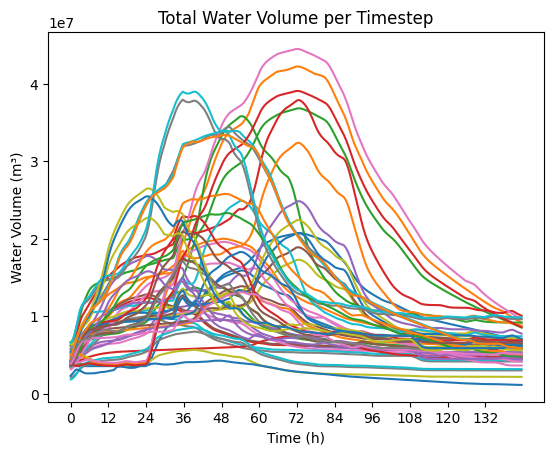

In [7]:
dynamic_nodes_paths = dataset.processed_paths[4:(num_events + 4)]
node_data_key = 'dynamic_nodes'
water_volume_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('water_volume')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='water_volume',
    feature_idx=water_volume_idx,
    ylabel='Water Volume (m³)',
    title='Total Water Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

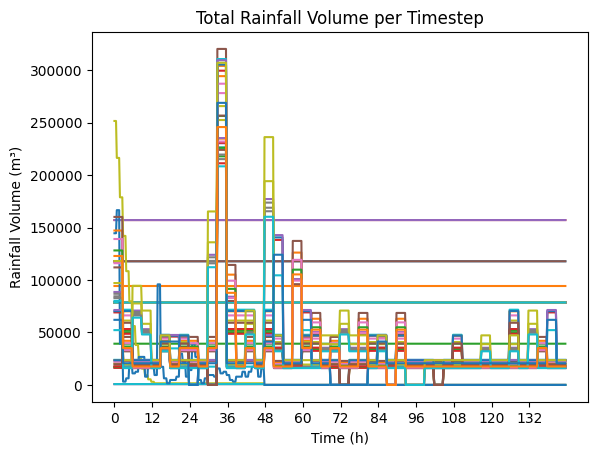

In [8]:
rainfall_idx = FloodEventDataset.DYNAMIC_NODE_FEATURES.index('rainfall')

plot_timeseries_per_event(
    dynamic_paths=dynamic_nodes_paths,
    data_key=node_data_key,
    feature_name='rainfall',
    feature_idx=rainfall_idx,
    ylabel='Rainfall Volume (m³)',
    title='Total Rainfall Volume per Timestep',
    aggregation_func=lambda x: x.sum(axis=1),
)

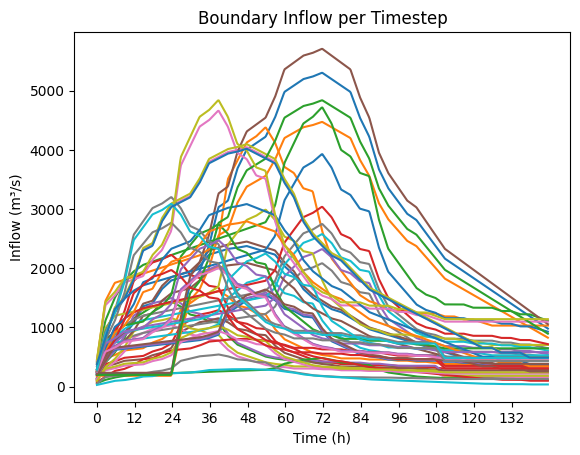

In [ ]:
# Plot total inflow per timestep
dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]
edge_data_key = 'dynamic_edges'
flow_idx = FloodEventDataset.DYNAMIC_EDGE_FEATURES.index('face_flow')
inflow_edge_mask = dataset.boundary_condition.inflow_edges_mask

plot_timeseries_per_event(
    dynamic_paths=dynamic_edges_paths,
    data_key=edge_data_key,
    feature_name='face_flow',
    feature_idx=flow_idx,
    ylabel='Inflow (m³/s)',
    title='Boundary Inflow per Timestep',
    mask=inflow_edge_mask,
)

In [10]:
event_end_idx = [*dataset.event_start_idx, dataset.total_rollout_timesteps]
event_size = np.diff(event_end_idx)

for i, run_id in enumerate(dataset.hec_ras_run_ids):
    print(f'Run {run_id} - Event Size: {event_size[i]} timesteps')

Run 17 - Event Size: 574 timesteps
Run 18 - Event Size: 574 timesteps
Run 19 - Event Size: 574 timesteps
Run 20 - Event Size: 574 timesteps
Run 21 - Event Size: 574 timesteps
Run 22 - Event Size: 574 timesteps
Run 23 - Event Size: 574 timesteps
Run 24 - Event Size: 574 timesteps
Run 25 - Event Size: 574 timesteps
Run 26 - Event Size: 574 timesteps
Run 27 - Event Size: 574 timesteps
Run 28 - Event Size: 574 timesteps
Run 29 - Event Size: 574 timesteps
Run 30 - Event Size: 574 timesteps
Run 31 - Event Size: 574 timesteps
Run 32 - Event Size: 574 timesteps
Run 33 - Event Size: 574 timesteps
Run 34 - Event Size: 574 timesteps
Run 35 - Event Size: 574 timesteps
Run 36 - Event Size: 574 timesteps
Run 37 - Event Size: 574 timesteps
Run 42 - Event Size: 574 timesteps
Run 43 - Event Size: 574 timesteps
Run 44 - Event Size: 574 timesteps
Run 45 - Event Size: 574 timesteps
Run 46 - Event Size: 574 timesteps
Run 47 - Event Size: 574 timesteps
Run 48 - Event Size: 574 timesteps
Run 49 - Event Size:

Nodes with the highest water volume difference:
Node 1081: 202839.39 m
Node 329: 202682.75 m
Node 1023: 198914.70 m
Node 1082: 198482.64 m
Node 1022: 192230.75 m


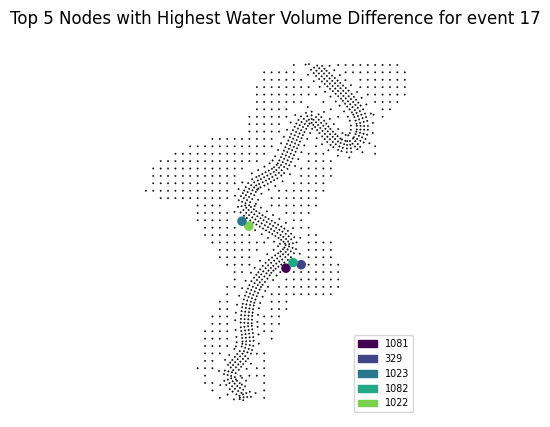

In [11]:
def get_highest_diff_entities(dynamic_path: str,
                              data_key: str,
                              feature_name: str,
                              feature_idx: int,
                              k: int = 4) -> Tuple[List, np.ndarray]:
    data = np.load(dynamic_path)[data_key]
    feature_data = data[:, :, feature_idx]
    feature_data = dataset.normalizer.denormalize(feature_name, feature_data)
    feature_diff = np.abs(np.diff(feature_data, axis=0))
    feature_diff_per_entity = feature_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(feature_diff_per_entity)[-k:][::-1].tolist()
    top_k_wd_diff = feature_diff_per_entity[top_k_diff_idx]
    return top_k_diff_idx, top_k_wd_diff


EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top nodes to retrieve

event_dynamic_nodes_path = dynamic_nodes_paths[EVENT_IDX]
top_k_wv_diff_idx, top_k_wv_diff = get_highest_diff_entities(dynamic_path=event_dynamic_nodes_path,
                                                             data_key=node_data_key,
                                                             feature_name='water_volume',
                                                             feature_idx=water_volume_idx,
                                                             k=k)
print('Nodes with the highest water volume difference:')
for idx, wv in zip(top_k_wv_diff_idx, top_k_wv_diff):
    print(f"Node {idx}: {wv:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
node_df = plot_utils.get_node_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=node_df,
                                     title=f'Top {k} Nodes with Highest Water Volume Difference for event {run_id}',
                                     highlight_idxs=top_k_wv_diff_idx)

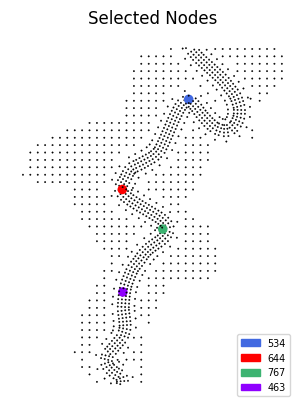

In [12]:
highlight_node_idx = [534, 644, 767, 463]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(node_df,
                                    title='Selected Nodes',
                                    highlight_idxs=highlight_node_idx,
                                    color_list=color_list,
                                    legend=False)

Edges with the highest water flow difference:
Edge 2471: 4348.12 m
Edge 1732: 4332.65 m
Edge 1609: 4227.90 m
Edge 1611: 4103.92 m
Edge 1639: 4026.16 m


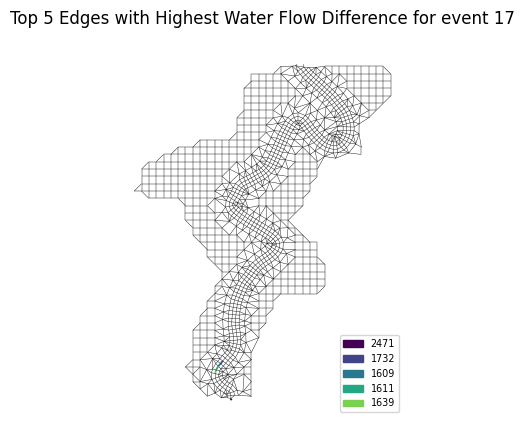

In [ ]:
def get_highest_diff_water_flow_edges(dataset: FloodEventDataset, event_idx: int, k: int = 4) -> tuple[list, np.ndarray]:
    num_events = len(dataset.hec_ras_run_ids)
    dynamic_edges_paths = dataset.processed_paths[4:(num_events + 4)]

    dynamic_edges = np.load(dynamic_edges_paths[event_idx])['dynamic_edges']
    water_flow_idx = FloodEventDataset.DYNAMIC_EDGE_FEATURES.index(FloodEventDataset.EDGE_TARGET_FEATURE)
    water_flow = dynamic_edges[:, :, water_flow_idx]
    water_flow = dataset.normalizer.denormalize(FloodEventDataset.EDGE_TARGET_FEATURE, water_flow)
    wf_diff = np.abs(np.diff(water_flow, axis=0))
    wf_diff_per_edge = wf_diff.sum(axis=0)

    top_k_diff_idx = np.argsort(wf_diff_per_edge)[-k:][::-1].tolist()
    top_k_wf_diff = wf_diff_per_edge[top_k_diff_idx]
    return top_k_diff_idx, top_k_wf_diff

EVENT_IDX = 0  # Change this to the desired event index
k = 5  # Number of top edges to retrieve

event_dynamic_edges_path = dynamic_edges_paths[EVENT_IDX]
top_k_wf_diff_idx, top_k_wf_diff = get_highest_diff_entities(dynamic_path=event_dynamic_edges_path,
                                                             data_key=edge_data_key,
                                                             feature_name='face_flow',
                                                             feature_idx=flow_idx,
                                                             k=k)
print('Edges with the highest water flow difference:')
for idx, wf in zip(top_k_wf_diff_idx, top_k_wf_diff):
    print(f"Edge {idx}: {wf:.2f} m")

run_id = dataset.hec_ras_run_ids[EVENT_IDX]
edge_df = plot_utils.get_edge_df(config, run_id, mode=mode, no_ghost=True)
plot_utils.plot_cell_map_w_highlight(gpdf=edge_df,
                                     title=f'Top {k} Edges with Highest Water Flow Difference for event {run_id}',
                                     highlight_idxs=top_k_wf_diff_idx)

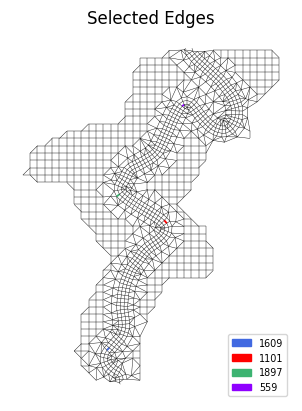

In [14]:
highlight_edge_idx = [1609, 1101, 1897, 559]
color_list = ['#4169E1', '#FF0000', '#3CB371', '#8F00FF']
plot_utils.plot_cell_map_w_highlight(edge_df,
                                     title='Selected Edges',
                                     highlight_idxs=highlight_edge_idx,
                                     color_list=color_list,
                                     legend=True)

In [15]:
feature_stats_path = dataset.processed_paths[1]
feature_stats = file_utils.read_yaml_file(feature_stats_path)
print("Feature statistics:")
for feature_name, stats in feature_stats.items():
    print(f"{feature_name}")
    print(f"\tMean: {stats['mean']:.4f}")
    print(f"\tStd: {stats['std']:.4f}")
    print(f"\tMin: {stats['min']:.4f}")
    print(f"\tMax: {stats['max']:.4f}")

Feature statistics:
area
	Mean: 27849.5664
	Std: 17814.3047
	Min: 0.0000
	Max: 117583.6875
aspect
	Mean: 176.5098
	Std: 104.6543
	Min: 0.0000
	Max: 359.8617
curvature
	Mean: 0.0002
	Std: 0.0005
	Min: 0.0000
	Max: 0.0085
elevation
	Mean: 105.5253
	Std: 43.6278
	Min: 0.0000
	Max: 319.1630
face_flow
	Mean: 12.0708
	Std: 273.7484
	Min: -4741.8276
	Max: 5704.7056
face_length
	Mean: 138.3993
	Std: 57.5719
	Min: 0.0000
	Max: 396.0271
flow_accumulation
	Mean: 1.6652
	Std: 1.5622
	Min: 0.0000
	Max: 15.0000
inflow
	Mean: 1188.4233
	Std: 1028.5288
	Min: 0.0000
	Max: 5704.7056
length
	Mean: 165.2975
	Std: 66.8252
	Min: 0.0000
	Max: 473.5640
position_x
	Mean: 318969.7500
	Std: 16519.0059
	Min: 0.0000
	Max: 323218.0625
position_y
	Mean: 6352800.0000
	Std: 327920.5000
	Min: 0.0000
	Max: 6373564.0000
rainfall
	Mean: 43.3244
	Std: 56.5489
	Min: 0.0000
	Max: 1198.1914
relative_position_x
	Mean: -13.9560
	Std: 125.9932
	Min: -398.5938
	Max: 424.3438
relative_position_y
	Mean: 28.5439
	Std: 122.0886
	Min:

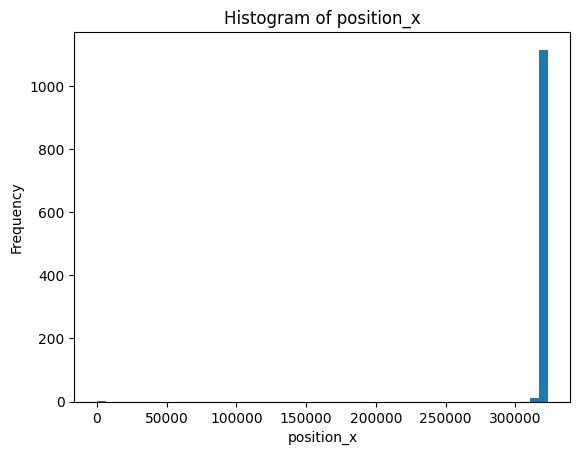

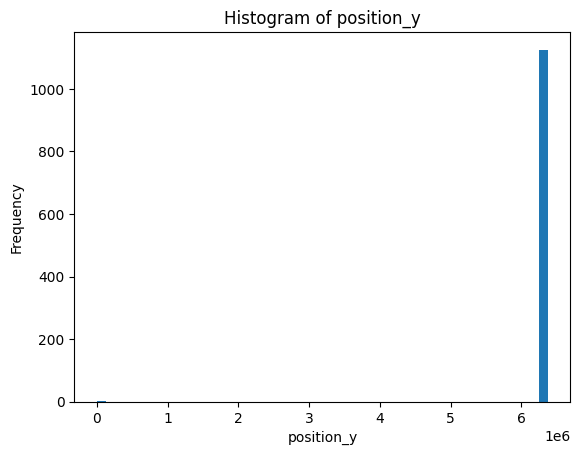

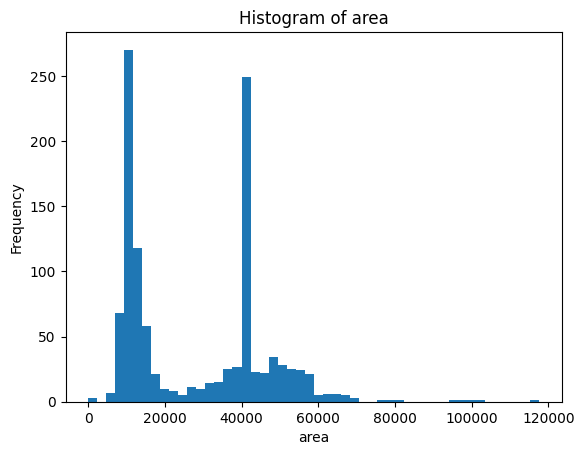

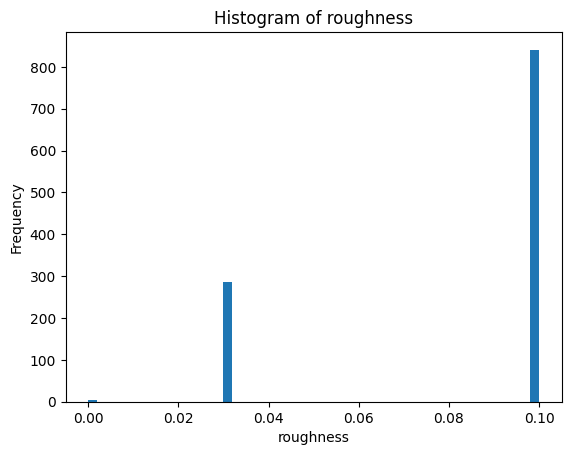

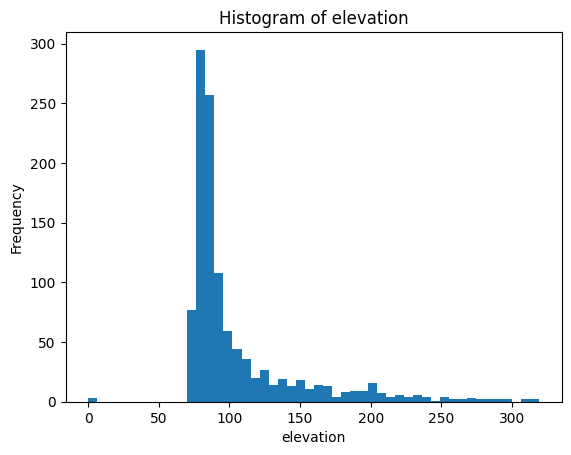

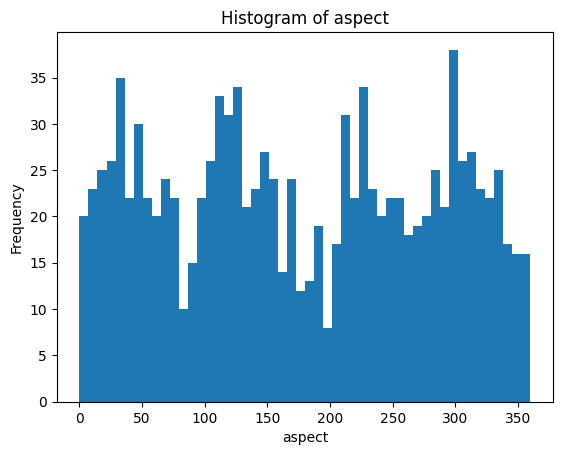

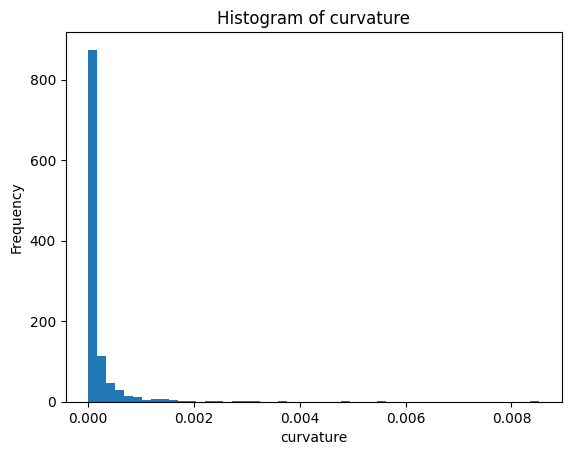

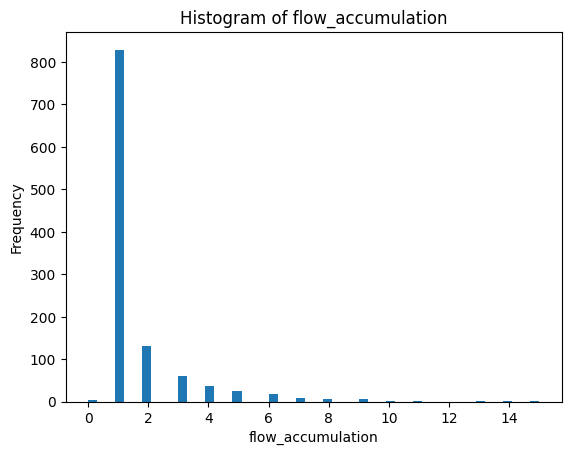

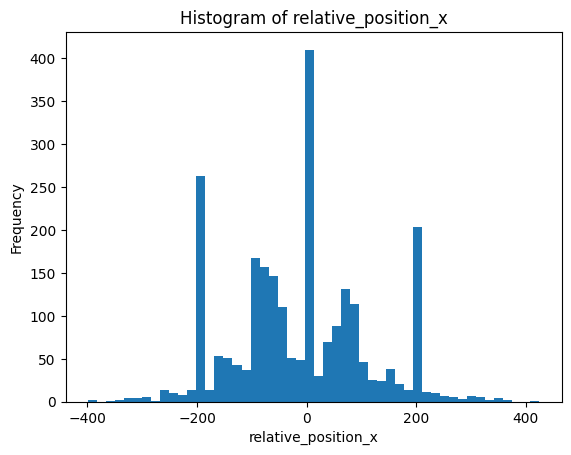

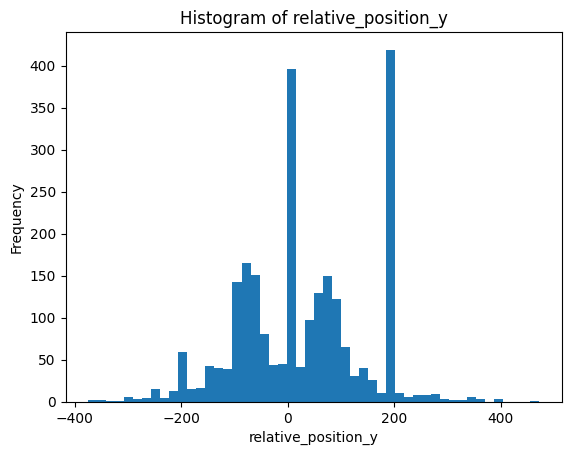

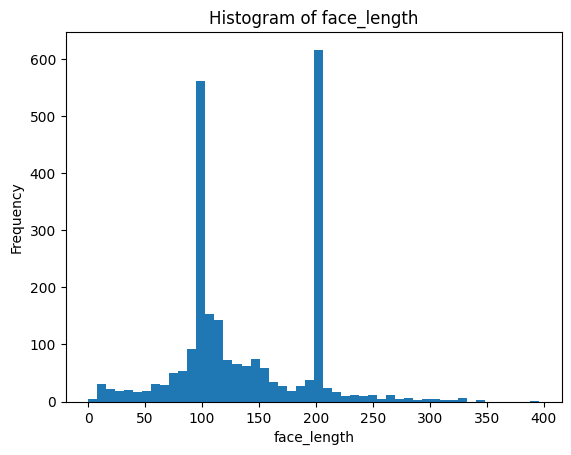

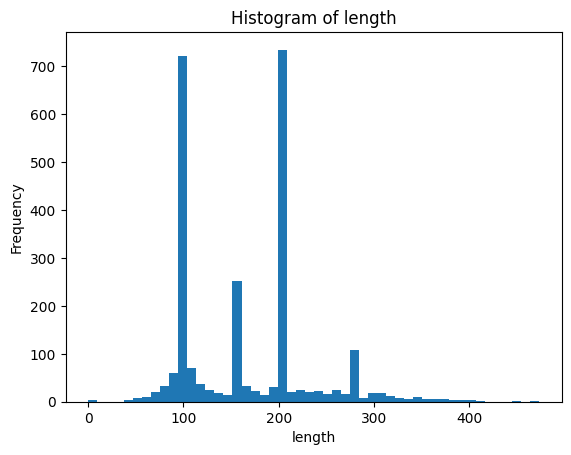

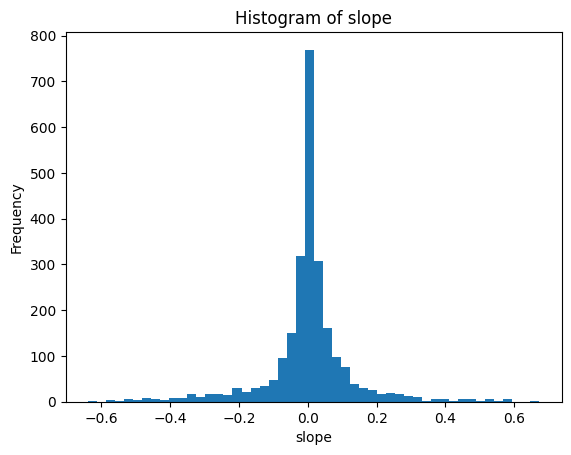

In [16]:
constant_values_path = dataset.processed_paths[3]
bins = 50

static_features = FloodEventDataset.STATIC_NODE_FEATURES + FloodEventDataset.STATIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_static_node_features)), *(range(dataset.num_static_edge_features))]
keys = [*(['static_nodes'] * dataset.num_static_node_features), *(['static_edges'] * dataset.num_static_edge_features)]
for feature, index, key in zip(static_features, feature_idxs, keys):
    data = np.load(constant_values_path)[key]
    feature_data = data[:, index]
    if dataset.is_normalized:
        feature_data = dataset.normalizer.denormalize(feature, feature_data)
    plt.hist(feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()

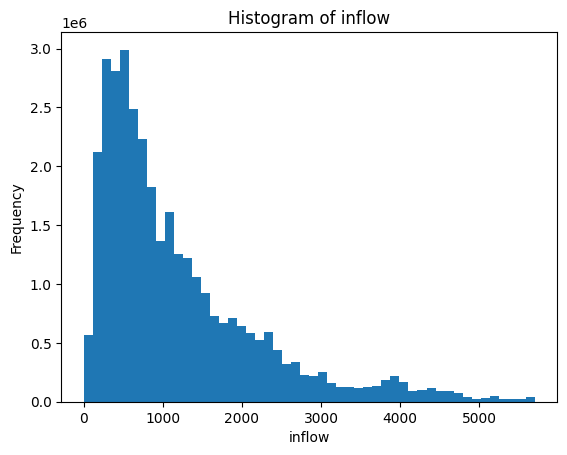

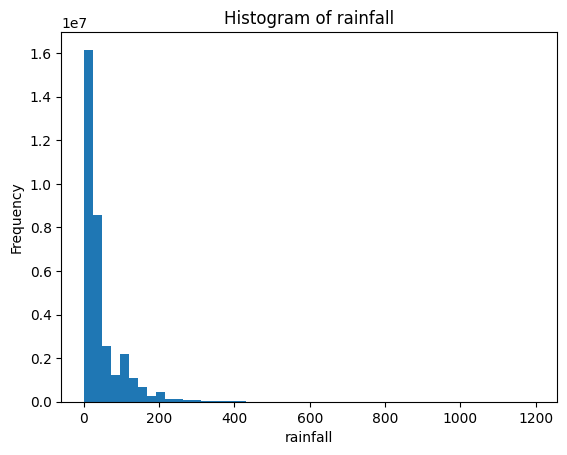

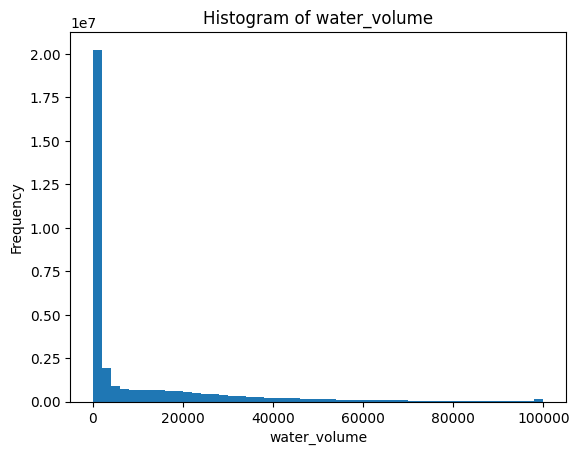

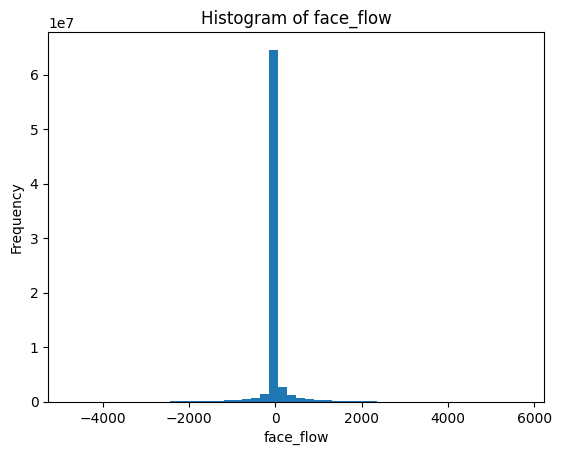

In [17]:
num_events = len(dataset.hec_ras_run_ids)
dynamic_values_paths = dataset.processed_paths[4:(num_events + 4)]

dynamic_features = FloodEventDataset.DYNAMIC_NODE_FEATURES + FloodEventDataset.DYNAMIC_EDGE_FEATURES
feature_idxs = [*(range(dataset.num_dynamic_node_features)), *(range(dataset.num_dynamic_edge_features))]
keys = [*(['dynamic_nodes'] * dataset.num_dynamic_node_features), *(['dynamic_edges'] * dataset.num_dynamic_edge_features)]
for feature, index, key in zip(dynamic_features, feature_idxs, keys):
    all_feature_data = []
    for path in dynamic_values_paths:
        data = np.load(path)[key]
        feature_data = data[:, :, index]
        if dataset.is_normalized:
            feature_data = dataset.normalizer.denormalize(feature, feature_data)
        all_feature_data.append(feature_data.flatten())
    all_feature_data = np.concatenate(all_feature_data)
    plt.hist(all_feature_data, bins=bins)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.show()
